In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# h1 = -sin(10pi(x+1)) / (2x+1) - x^4 + e1
# y1 = h1 + e1
# h2 = cos^2(h1(x) + sin(3x)) + e2
# y2 = h2 + e2
# h3 = y2(x) y1^2(x) + 3x + e3
# y3 = h3 + e3

In [161]:
N = 200
x = np.linspace(0.0,1.0,N).reshape(N,1)

f1 = lambda x: -np.sin(10*np.pi*(x+1))/(2*x+1)-x**4
h1 = lambda x: f1(x) + np.random.normal(0,1e-5)
y1 = np.array(list(map(h1,x))) + np.random.normal(0,0.05,N).reshape(N,1)

f2 = lambda x: np.cos(h1(x))**2 + np.sin(3*x)
h2 = lambda x: f2(x) + np.random.normal(0,1e-5)
y2 = np.array(list(map(h2,x))) + np.random.normal(0,0.05,N).reshape(N,1)

f3 = lambda x: h2(x)*h1(x)**2 + 3*x
h3 = lambda x: f3(x) + np.random.normal(0,1e-5)
y3 = np.array(list(map(h3,x))) + np.random.normal(0,0.05,N).reshape(N,1)

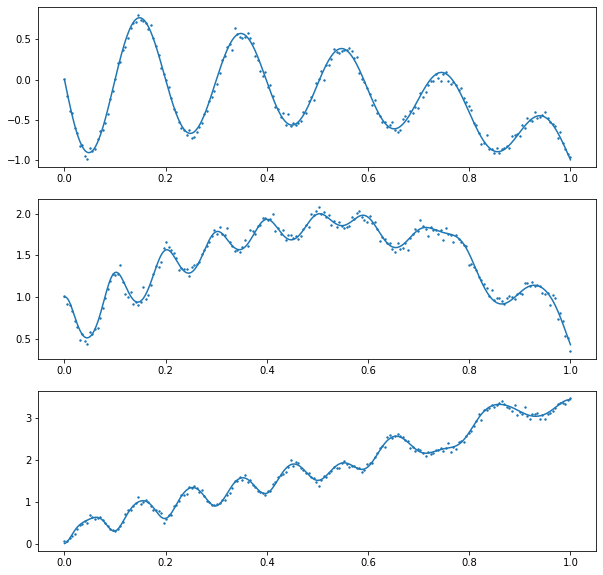

In [162]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x,y1, s=2)
x_ = np.linspace(0.0,1.0,1000)
h1_ = np.array(list(map(f1,x_)))
ax1.plot(x_,h1_)

ax2.scatter(x,y2, s=2)
f2_ = lambda x: np.cos(f1(x))**2 + np.sin(3*x)
h2_ = np.array(list(map(f2_,x_)))
ax2.plot(x_,h2_)

ax3.scatter(x,y3, s=2)
f3_ = lambda x: f2_(x)*f1(x)**2 + 3*x
h3_ = np.array(list(map(f3_,x_)))
ax3.plot(x_,h3_)

In [67]:
import gpflow
import tensorflow as tf
import sys
sys.path.append('../code')

In [68]:
from gplar import GPLARegressor

In [163]:
y = np.concatenate((y1,y2,y3),axis=-1)
x_obs, y_obs = x[::5], y[::5]
x_obs.shape

(40, 1)

In [164]:
M = 20 # number of inducing points
m = GPLARegressor(x_obs, y_obs, M, white=False,
                 scale=0.1,
                 linear=True, linear_scale=10.0,
                 nonlinear=True, nonlinear_scale=0.1,
                 noise_inner=1e-5, noise_obs=0.05,
                 num_samples=100)

In [174]:
M = 50 # number of inducing points
m_50 = GPLARegressor(x, y, M, white=False,
                 scale=0.1,
                 linear=True, linear_scale=10.0,
                 nonlinear=True, nonlinear_scale=0.1,
                 noise_inner=1e-5, noise_obs=0.05,
                 num_samples=10)

In [175]:
@tf.function(autograph=False)
def optimization_step(optimizer, model, data):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = -model.maximum_log_likelihood_objective(*data)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, data, iterations):
    logf=[]
    adam = tf.optimizers.Adam(0.01)
    for step in range(iterations):
        neg_elbo = optimization_step(adam, model, data)
        elbo = -neg_elbo
        if step%10 == 0:
            logf.append(elbo.numpy())
        if step%500 == 0:
            print(elbo.numpy())
    return logf

In [172]:
gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPLARegressor.likelihoods[0].variance GPLARegressor.likelihoods[1].variance GPLARegressor.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,0.008862865036002884
GPLARegressor.layers[0].inducing_points.Z,Parameter,,,False,"(20, 1)",float64,[[0.22613065...
GPLARegressor.layers[0].q_mu,Parameter,,,True,"(20, 1)",float64,[[-0.47362696...
GPLARegressor.layers[0].q_sqrt,Parameter,FillTriangular,,True,"(20, 20)",float64,"[[3.54070936e-02, 0.00000000e+00, 0.00000000e+00..."
GPLARegressor.layers[0].kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,4.428463675176652
GPLARegressor.layers[0].kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.10960399953784014
GPLARegressor.layers[0].kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,4.620084523143969e-06
GPLARegressor.layers[1].inducing_points.Z,Parameter,,,False,"(20, 2)",float64,"[[0.22613065, -0.52584673..."
GPLARegressor.layers[1].q_mu,Parameter,,,True,"(20, 1)",float64,[[1.33240605...
GPLARegressor.layers[1].q_sqrt,Parameter,FillTriangular,,True,"(20, 20)",float64,"[[3.53637162e-02, 0.00000000e+00, 0.00000000e+00..."


-1761.9834197650894
-35.19162703385673
-2.4296509938889272
11.365067070887662
3.973315882711745
16.94023842337286


Text(0.5, 1.0, 'ELBO of GPLAR')

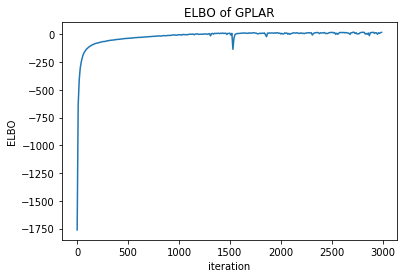

In [167]:
from gpflow.ci_utils import ci_niter
maxiter = ci_niter(3000)
logf = run_adam(m, (x_obs,y_obs), maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of GPLAR')

-5237.759057118278
736.0970910592617
788.0139027579013
797.330778491187
801.2374394079743
803.4758801654071


Text(0.5, 1.0, 'ELBO of GPLAR with 200 datapoints and 50 inducing points')

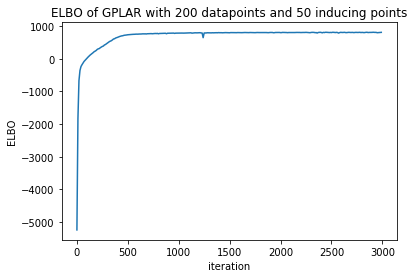

In [176]:
from gpflow.ci_utils import ci_niter
maxiter = ci_niter(3000)
logf = run_adam(m_50, (x,y), maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of GPLAR with 200 datapoints and 50 inducing points')

In [177]:
Hmeans, Hvars = m.predict_f(x, 200)
Hmeans_50, Hvars_50 = m_50.predict_f(x, 200)

In [183]:
Hmeans_50, Hvars_50 = m_50.predict_f(x, 200)

In [184]:
def getMeanandBound(Hmeans,Hvars):
    result = []
    for i in range(len(Hmeans)):
        mean = tf.reduce_mean(Hmeans[i],axis=0)
        sd = tf.sqrt(tf.reduce_mean(Hvars[i],axis=0))
        
        result.append([mean,mean+3*sd, mean-3*sd])
        
    return result

predict_y = getMeanandBound(Hmeans, Hvars)
predict_y_50 = getMeanandBound(Hmeans_50, Hvars_50)

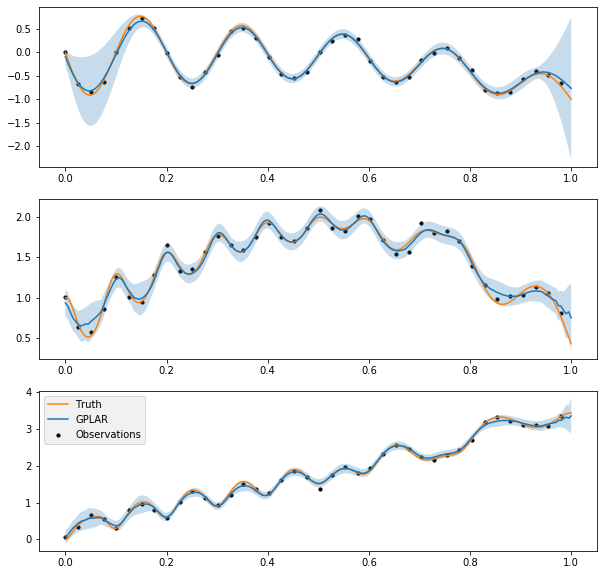

In [170]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x_obs,y_obs[:,0:1],s=10, label='Observations',c='black')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x,predict_y[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x[:,0],predict_y[0][2][:,0], predict_y[0][1][:,0],
                facecolor='tab:blue', alpha=.25)

ax2.scatter(x_obs,y_obs[:,1:2],s=10,label='Observations',c='black')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x,predict_y[1][0], label='GPLAR', c='tab:blue')
ax2.fill_between(x[:,0],predict_y[1][2][:,0], predict_y[1][1][:,0],
                facecolor='tab:blue', alpha=.25)

ax3.scatter(x_obs,y_obs[:,2:],s=10,label='Observations',c='black')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x,predict_y[2][0], label='GPLAR', c='tab:blue')
ax3.fill_between(x[:,0],predict_y[2][2][:,0], predict_y[2][1][:,0],
                facecolor='tab:blue', alpha=.25)

plt.legend(facecolor='#eeeeee')

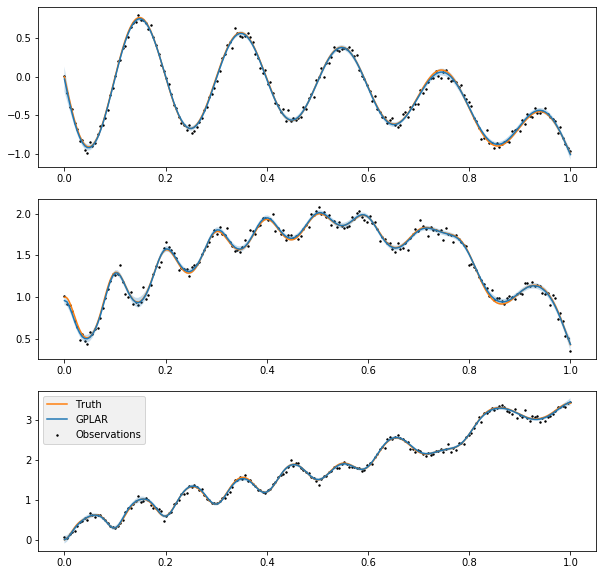

In [185]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x,y1,s=2, label='Observations',c='black')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x,predict_y_50[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x[:,0],predict_y_50[0][2][:,0], predict_y_50[0][1][:,0],
                facecolor='tab:blue', alpha=.25)

ax2.scatter(x,y2,s=2,label='Observations',c='black')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x,predict_y_50[1][0], label='GPLAR', c='tab:blue')
ax2.fill_between(x[:,0],predict_y_50[1][2][:,0], predict_y_50[1][1][:,0],
                facecolor='tab:blue', alpha=.25)

ax3.scatter(x,y3,s=2,label='Observations',c='black')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x,predict_y_50[2][0], label='GPLAR', c='tab:blue')
ax3.fill_between(x[:,0],predict_y_50[2][2][:,0], predict_y_50[2][1][:,0],
                facecolor='tab:blue', alpha=.25)

plt.legend(facecolor='#eeeeee')